In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import scipy.stats as stats
import os 
import h5py
import sys
%matplotlib inline 

In [2]:
model_name = "SameScale.h5py"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'j7_eta', 'j7_phi','j7_m', 'j7_DL1r', 'j8_pt', 'j8_eta', 'j8_phi','j8_m', 'j8_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi','j7_phi','j7_phi', 'j8_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'j7_eta', 'j8_eta', 'lep_eta', 'th_eta', 'tl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','j7_pt','j8_pt','lep_pt','th_pt', 'tl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m','j7_m','j8_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r','j7_DL1r','j8_DL1r',]

output_length = len(output_keys)
input_length = len(input_keys)

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

# def phi_transform1(arr, max0, mean):
#     arr = (arr-mean)
#     arr = arr/max0/1.01
#     return (z, max0, mean)

# def invphi_transform1(z, max0, mean):
#     arr = arr*np.pi*1.01+mean
#     return arr

def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            z = meanmax_transform(var, max0, mean)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize
crop0 =  1000000 # Must be even
maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)

total_output = scale_arrays(output_keys, maxmean)

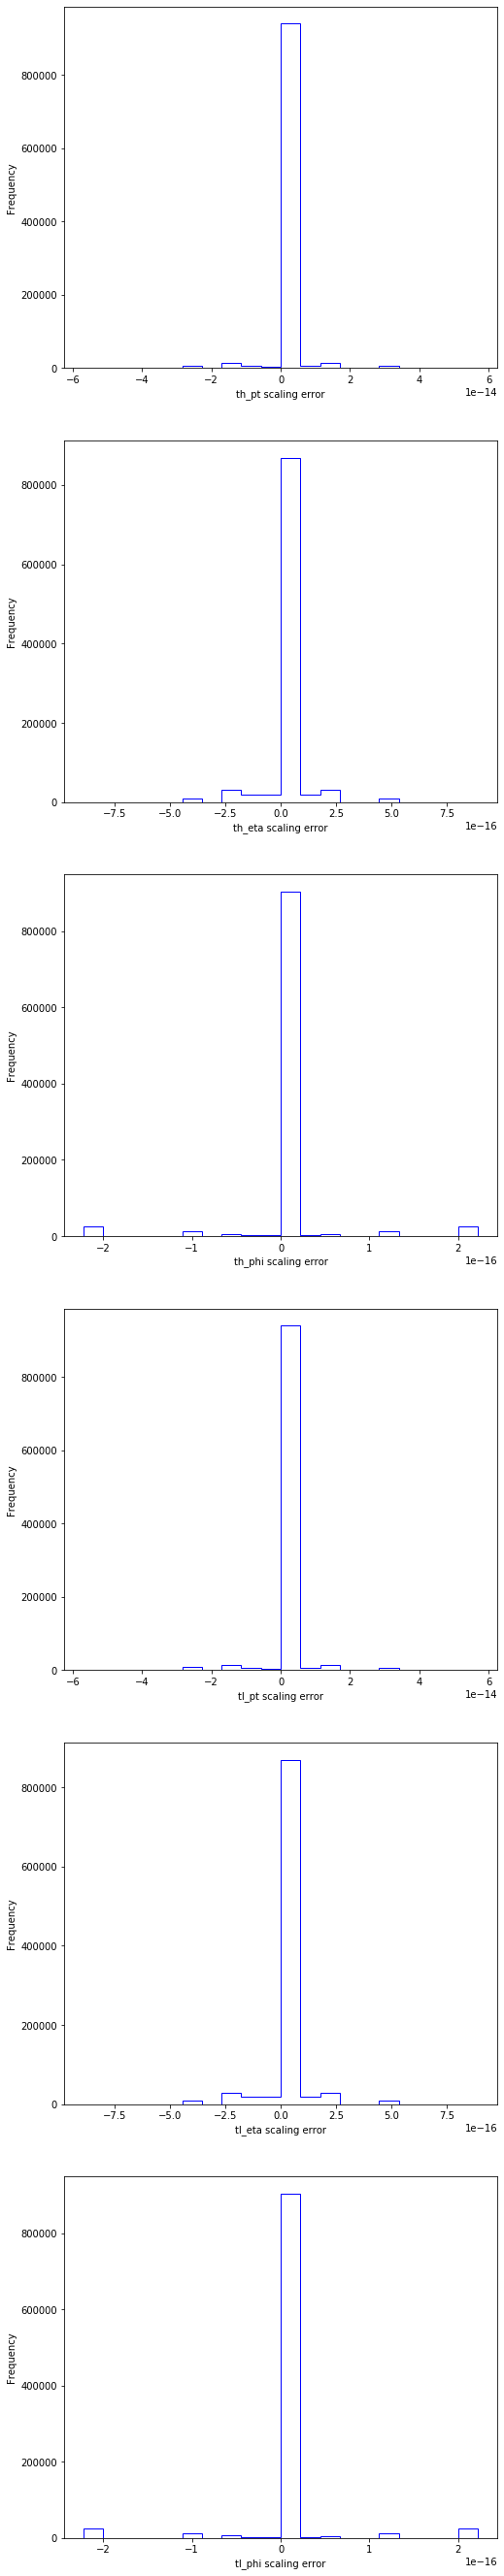

In [8]:
# Test inverse scaling

out_scaled = invscale_arrays(output_keys, total_output, maxmean)

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(800000, 45) (800000, 6)
(200000, 45) (200000, 6)


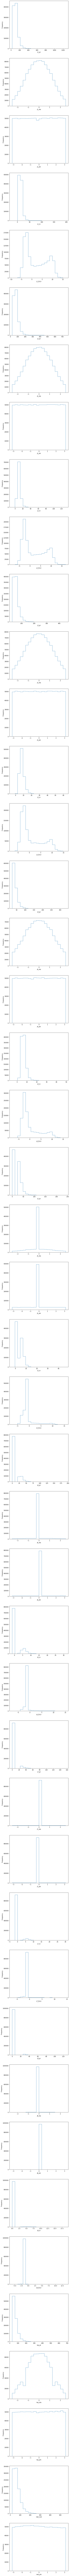

In [11]:
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(np.array(dataset.get(input_keys[i]))[0:crop0], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

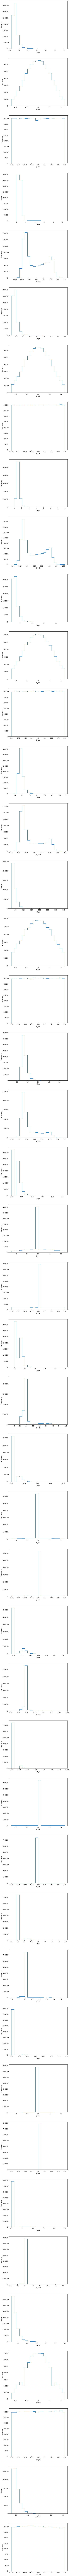

In [12]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [13]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23552     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 270,854
Trainable params: 270,854
Non-trainable params: 0
__________________________________________________

In [15]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=128)


Epoch 1/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.1678 - mse: 0.0879 - val_loss: 0.1489 - val_mse: 0.0817
Epoch 2/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.1397 - mse: 0.0793 - val_loss: 0.1331 - val_mse: 0.0777
Epoch 3/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.1285 - mse: 0.0762 - val_loss: 0.1252 - val_mse: 0.0754
Epoch 4/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.1222 - mse: 0.0743 - val_loss: 0.1199 - val_mse: 0.0738
Epoch 5/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.1176 - mse: 0.0729 - val_loss: 0.1160 - val_mse: 0.0726
Epoch 6/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.1141 - mse: 0.0719 - val_loss: 0.1127 - val_mse: 0.0717
Epoch 7/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.1111 - mse: 0.0711 - val_loss: 0.1100 - val_mse: 0.0709
Epoch 8/2048
5000/5000 [=================

5000/5000 [==============================] - 22s 4ms/step - loss: 0.0763 - mse: 0.0632 - val_loss: 0.0775 - val_mse: 0.0644
Epoch 61/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0761 - mse: 0.0631 - val_loss: 0.0773 - val_mse: 0.0643
Epoch 62/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0759 - mse: 0.0630 - val_loss: 0.0771 - val_mse: 0.0643
Epoch 63/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0757 - mse: 0.0630 - val_loss: 0.0769 - val_mse: 0.0642
Epoch 64/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0755 - mse: 0.0629 - val_loss: 0.0767 - val_mse: 0.0641
Epoch 65/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0753 - mse: 0.0628 - val_loss: 0.0766 - val_mse: 0.0641
Epoch 66/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0751 - mse: 0.0627 - val_loss: 0.0764 - val_mse: 0.0640
Epoch 67/2048
5000/5000 [=======================

5000/5000 [==============================] - 22s 4ms/step - loss: 0.0688 - mse: 0.0597 - val_loss: 0.0711 - val_mse: 0.0620
Epoch 120/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0688 - mse: 0.0597 - val_loss: 0.0711 - val_mse: 0.0620
Epoch 121/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0687 - mse: 0.0596 - val_loss: 0.0710 - val_mse: 0.0620
Epoch 122/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0686 - mse: 0.0596 - val_loss: 0.0710 - val_mse: 0.0620
Epoch 123/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0686 - mse: 0.0596 - val_loss: 0.0709 - val_mse: 0.0619
Epoch 124/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0685 - mse: 0.0595 - val_loss: 0.0709 - val_mse: 0.0619
Epoch 125/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0684 - mse: 0.0595 - val_loss: 0.0708 - val_mse: 0.0619
Epoch 126/2048
5000/5000 [================

5000/5000 [==============================] - 22s 4ms/step - loss: 0.0659 - mse: 0.0580 - val_loss: 0.0691 - val_mse: 0.0613
Epoch 179/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0658 - mse: 0.0580 - val_loss: 0.0691 - val_mse: 0.0612
Epoch 180/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0658 - mse: 0.0580 - val_loss: 0.0690 - val_mse: 0.0612
Epoch 181/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0657 - mse: 0.0579 - val_loss: 0.0690 - val_mse: 0.0612
Epoch 182/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0657 - mse: 0.0579 - val_loss: 0.0690 - val_mse: 0.0612
Epoch 183/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0657 - mse: 0.0579 - val_loss: 0.0690 - val_mse: 0.0612
Epoch 184/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0656 - mse: 0.0579 - val_loss: 0.0690 - val_mse: 0.0612
Epoch 185/2048
5000/5000 [================

5000/5000 [==============================] - 22s 4ms/step - loss: 0.0641 - mse: 0.0568 - val_loss: 0.0681 - val_mse: 0.0609
Epoch 238/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0641 - mse: 0.0568 - val_loss: 0.0681 - val_mse: 0.0608
Epoch 239/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0640 - mse: 0.0567 - val_loss: 0.0681 - val_mse: 0.0608
Epoch 240/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0640 - mse: 0.0567 - val_loss: 0.0681 - val_mse: 0.0608
Epoch 241/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0640 - mse: 0.0567 - val_loss: 0.0681 - val_mse: 0.0608
Epoch 242/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0640 - mse: 0.0567 - val_loss: 0.0681 - val_mse: 0.0608
Epoch 243/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0639 - mse: 0.0567 - val_loss: 0.0681 - val_mse: 0.0608
Epoch 244/2048
5000/5000 [================

5000/5000 [==============================] - 22s 4ms/step - loss: 0.0628 - mse: 0.0558 - val_loss: 0.0677 - val_mse: 0.0606
Epoch 297/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0628 - mse: 0.0557 - val_loss: 0.0677 - val_mse: 0.0606
Epoch 298/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0628 - mse: 0.0557 - val_loss: 0.0677 - val_mse: 0.0606
Epoch 299/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0628 - mse: 0.0557 - val_loss: 0.0676 - val_mse: 0.0606
Epoch 300/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0627 - mse: 0.0557 - val_loss: 0.0676 - val_mse: 0.0606
Epoch 301/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0627 - mse: 0.0557 - val_loss: 0.0676 - val_mse: 0.0606
Epoch 302/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0627 - mse: 0.0557 - val_loss: 0.0676 - val_mse: 0.0606
Epoch 303/2048
5000/5000 [================

5000/5000 [==============================] - 22s 4ms/step - loss: 0.0618 - mse: 0.0549 - val_loss: 0.0674 - val_mse: 0.0605
Epoch 356/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0618 - mse: 0.0549 - val_loss: 0.0674 - val_mse: 0.0605
Epoch 357/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0618 - mse: 0.0548 - val_loss: 0.0674 - val_mse: 0.0605
Epoch 358/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0618 - mse: 0.0548 - val_loss: 0.0674 - val_mse: 0.0605
Epoch 359/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0617 - mse: 0.0548 - val_loss: 0.0674 - val_mse: 0.0605
Epoch 360/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0617 - mse: 0.0548 - val_loss: 0.0674 - val_mse: 0.0605
Epoch 361/2048
5000/5000 [==============================] - 22s 4ms/step - loss: 0.0617 - mse: 0.0548 - val_loss: 0.0674 - val_mse: 0.0605
Epoch 362/2048
5000/5000 [================

In [16]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: SameScale.h5py/assets


Text(0.5, 1.0, 'MSE loss')

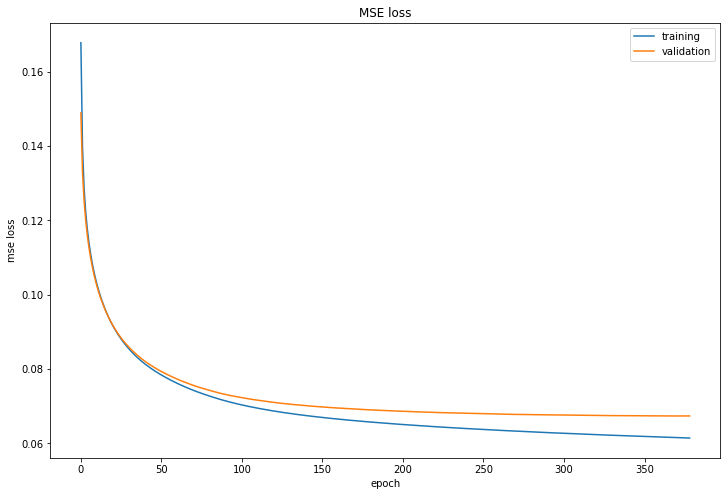

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [18]:
predictions = model.predict(test_input)

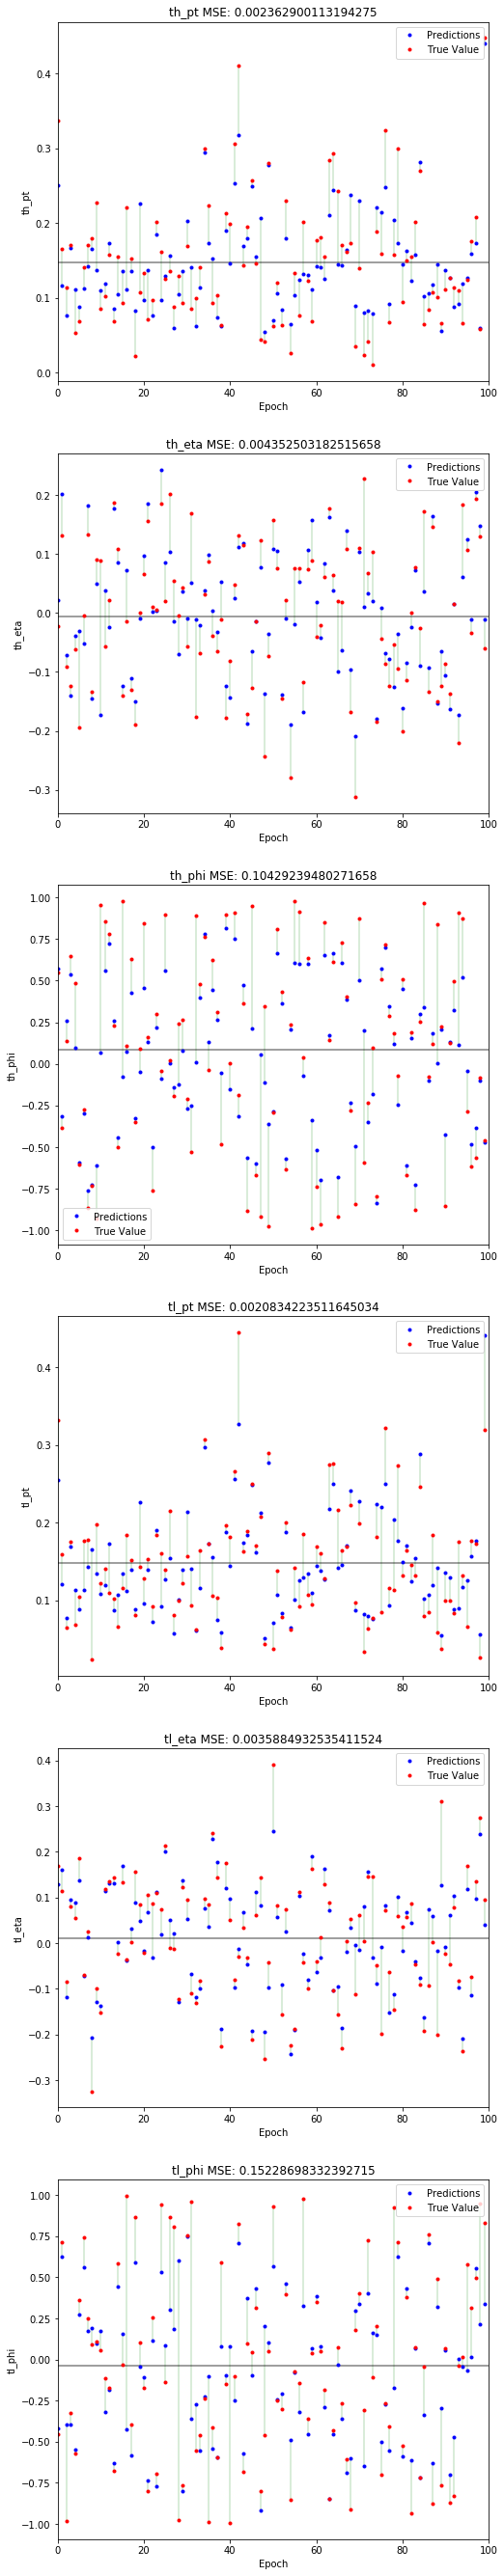

In [20]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [21]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.06028451072396216
th_pt MSE :  0.0023233681
th_eta MSE :  0.0060411380
th_phi MSE :  0.1893391962
tl_pt MSE :  0.0019882851
tl_eta MSE :  0.0045200461
tl_phi MSE :  0.1574950308


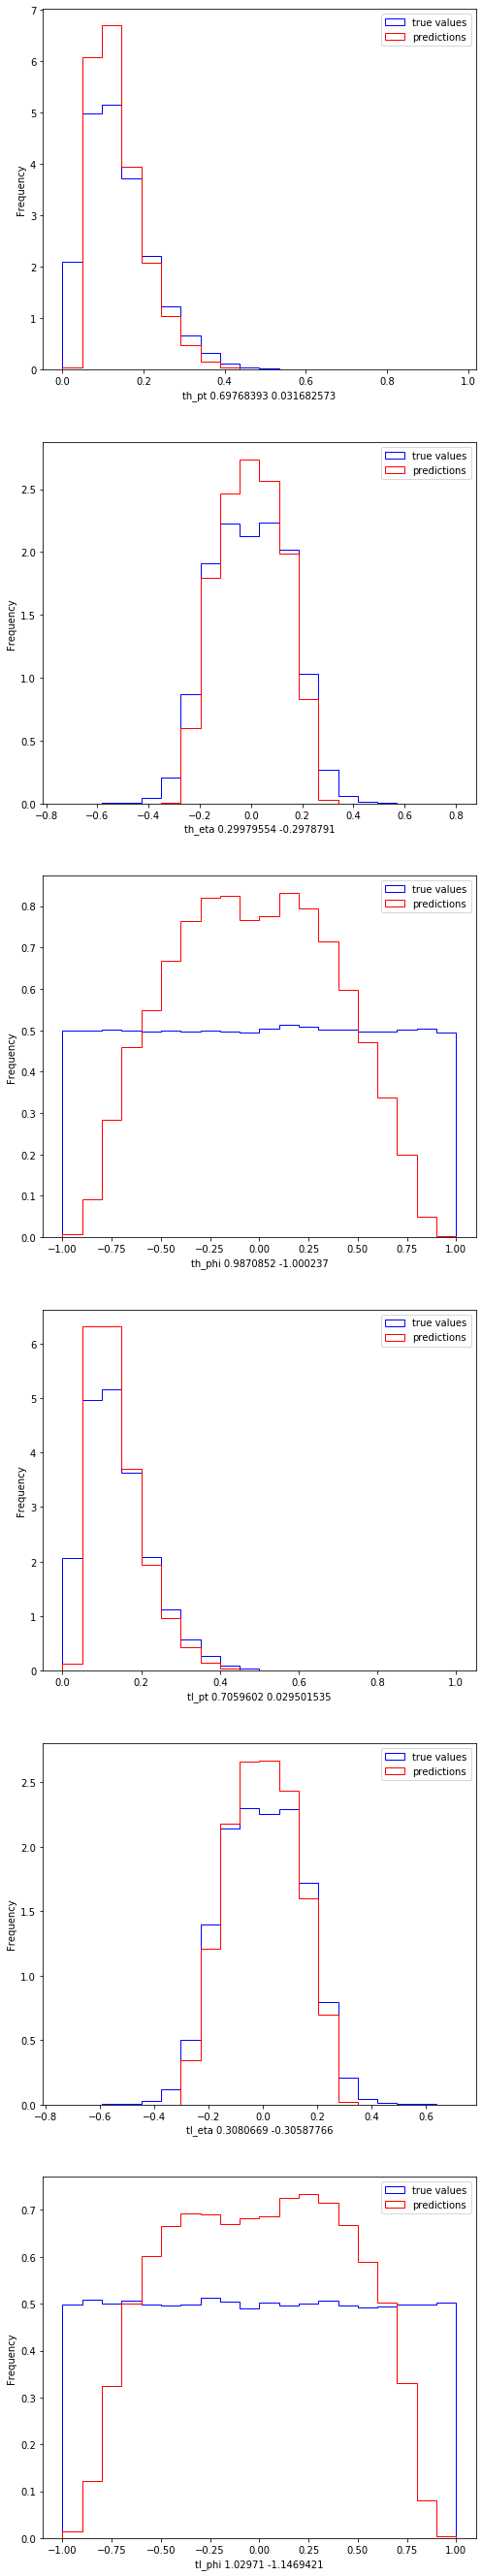

In [22]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

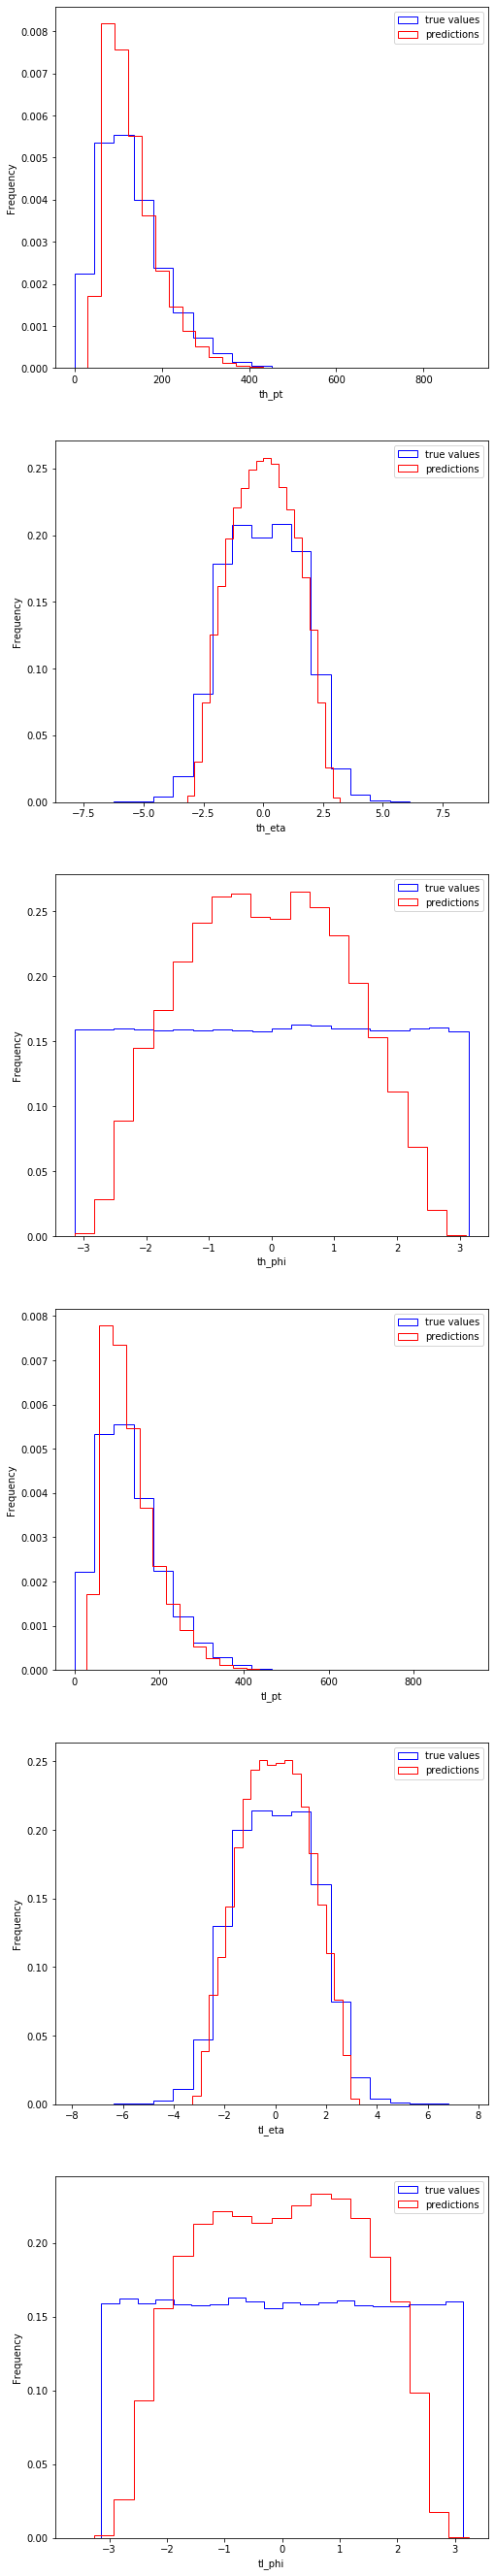

In [26]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]
predict_scaled = invscale_arrays(output_keys, predictions, maxmean)

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [27]:
for i in range(output_length):
    MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] -out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  2011.2412861456
Original Scale th_eta MSE :  0.6933715874
Original Scale th_phi MSE :  1.8687029683
Original Scale tl_pt MSE :  1721.1741205665
Original Scale tl_eta MSE :  0.5187882765
Original Scale tl_phi MSE :  1.5544136526
